In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

#### load 2011 hplc file

In [2]:
floc='/ocean/eolson/MEOPAR/obs/NemcekHPLC/2011 composition changes with depth.xlsx'
df0=pd.read_excel(floc,sheet_name='HPLC plots',verbose=True,na_values=(-99,-99.9),engine='openpyxl')

Reading sheet HPLC plots


In [3]:
for var in ('Diatoms-1','Diatoms-2','Prasinophytes','Cryptophytes','Dinoflagellates-1','Haptophytes','Dictyo',
            'Raphido','Cyanobacteria'):
    df0.rename(columns={var:var+'x'},inplace=True)

for var in ('Diatoms-1','Diatoms-2','Prasinophytes','Cryptophytes','Dinoflagellates-1','Haptophytes','Dictyo',
            'Raphido','Cyanobacteria'):
    df0[var]=df0[var+'x']*df0['T chl a']

for var in ('Diatoms-1','Diatoms-2','Prasinophytes','Cryptophytes','Dinoflagellates-1','Haptophytes','Dictyo',
            'Raphido','Cyanobacteria'):
    df0.drop(columns=(var+'x'),inplace=True)

df0.dropna(subset=('Diatoms-1','Diatoms-2',),how='all',inplace=True)

In [4]:
df0.head(5)

,Cruise,Month,Station,Distance,Sample#,depth,T chl a,% diatoms,Diatoms-1,Diatoms-2,Prasinophytes,Cryptophytes,Dinoflagellates-1,Haptophytes,Dictyo,Raphido,Cyanobacteria
0,2011-08,April,102,0.000000,176.0,0.0,2.28816,0.675847,1.4197,0.126747,0.123511,0.181151,0.224466,0.0500825,0.0467157,0.10959,0.00619676
1,2011-08,April,75,14.146700,190.0,0.0,2.34223,0.70811,1.15614,0.502418,0.184418,0.153775,0.185794,0.058737,0.035052,0.0658965,0
2,2011-08,April,72,53.777709,203.0,0.0,1.12654,0.498815,0.554218,0.00771505,0.195122,0.139457,0.0956432,0.0131673,0.0200251,0.0893818,0.0118066
3,2011-08,April,ADCP,111.226061,213.0,0.0,0.740453,0.637956,0.445945,0.0264313,0.153361,0.0725701,0.000924017,0,0.000739395,0.0404824,0
4,2011-08,April,65,121.933291,223.0,0.0,0.719871,0.586513,0.398758,0.0234555,0.163365,0.0763358,0.0265331,0,0.000587094,0.030837,0


In [5]:
from sqlalchemy import create_engine, case
from sqlalchemy.orm import create_session 
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import and_, or_, not_, func


In [9]:
basedir='/ocean/shared/SalishSeaCastData/DFO/BOT/'
dbname='DFO_OcProfDB.sqlite'
engine = create_engine('sqlite:///' + basedir + dbname, echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
JDFLocsTBL=Base.classes.JDFLocsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [12]:
qry=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                  StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
             StationTBL.MISSION,StationTBL.Lat,StationTBL.Lon,
             ObsTBL.Sample_Number,ObsTBL.Depth,ObsTBL.Pressure).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).filter(or_(StationTBL.MISSION=='2011-08',
                                                                StationTBL.MISSION=='2011-09',
                                                                StationTBL.MISSION=='2011-10'))
df1=pd.DataFrame(qry.all())

In [13]:
df1['Z']=np.where(df1['Depth']>=0,df1['Depth'],-1.0*gsw.z_from_p(p=df1['Pressure'],lat=df1['Lat']))
df1['dtUTC']=[dt.datetime(int(y),int(m),int(d))+dt.timedelta(hours=h) for y,m,d,h in zip(df1['Year'],df1['Month'],df1['Day'],df1['Hour'])]

In [14]:
df1

,Year,Month,Day,Hour,MISSION,Lat,Lon,Sample_Number,Depth,Pressure,Z,dtUTC
0,2011.0,4.0,14.0,13.470000,2011-08,49.961667,-125.146500,11.0,None,2.8,2.77599,2011-04-14 13:28:12
1,2011.0,4.0,14.0,13.470000,2011-08,49.961667,-125.146500,10.0,None,3.8,3.76741,2011-04-14 13:28:12
2,2011.0,4.0,14.0,13.470000,2011-08,49.961667,-125.146500,9.0,None,9.0,8.92269,2011-04-14 13:28:12
3,2011.0,4.0,14.0,13.470000,2011-08,49.961667,-125.146500,8.0,None,22.9,22.7025,2011-04-14 13:28:12
4,2011.0,4.0,14.0,13.470000,2011-08,49.961667,-125.146500,7.0,None,30.7,30.4347,2011-04-14 13:28:12
...,...,...,...,...,...,...,...,...,...,...,...,...
789,2011.0,9.0,12.0,11.890278,2011-10,49.318667,-123.799167,169.0,None,174.8,173.239,2011-09-12 11:53:25
790,2011.0,9.0,12.0,11.890278,2011-10,49.318667,-123.799167,168.0,None,200.2,198.4,2011-09-12 11:53:25
791,2011.0,9.0,12.0,11.890278,2011-10,49.318667,-123.799167,167.0,None,250.9,248.614,2011-09-12 11:53:25
792,2011.0,9.0,12.0,11.890278,2011-10,49.318667,-123.799167,166.0,None,300.1,297.33,2011-09-12 11:53:25


In [17]:
df=pd.merge(df0, df1,  how='inner', 
                 left_on=['Cruise','Sample#'], right_on = ['MISSION','Sample_Number'])

In [18]:
print(len(df0),len(df1),len(df))

172 794 172


In [58]:
df.keys()

Index(['Cruise', 'Month_x', 'Station', 'Distance', 'Sample#', 'depth',
       'T chl a', '% diatoms', 'Diatoms-1', 'Diatoms-2', 'Prasinophytes',
       'Cryptophytes', 'Dinoflagellates-1', 'Haptophytes', 'Dictyo', 'Raphido',
       'Cyanobacteria', 'Year', 'Month_y', 'Day', 'Hour', 'MISSION', 'Lat',
       'Lon', 'Sample_Number', 'Depth', 'Pressure', 'Z', 'dtUTC'],
      dtype='object')

In [60]:
np.unique(df1.Month),np.unique(df.Month_x),np.unique(df.Month_y)

(array([4., 6., 9.]),
 array(['April', 'June', 'Sept'], dtype=object),
 array([4., 6., 9.]))

In [19]:
# Parameters
modSourceDir = "/results2/SalishSea/nowcast-green.201905/"
modver = "201905"
Chl_N = 1.8
fname = "compHPLCModelFirstLook-Regress-201905.ipynb"
startYMD=(2011,4,1)
endYMD=(2011,10,1)

In [20]:
start_date = dt.datetime(startYMD[0],startYMD[1],startYMD[2])
end_date = dt.datetime(endYMD[0],endYMD[1],endYMD[2]) #dt.datetime(2019,6,30)

In [21]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [22]:
PATH= modSourceDir
flen=1
namfmt='nowcast'
filemap={'diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T',}
fdict={'ptrc_T':1,'grid_T':1}
data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)
print(np.unique(data.Month_y))
data.rename(columns={'Dictyo':'Dictyochophytes','Raphido':'Raphidophytes','Dinoflagellates-1':'Dinoflagellates'},
           inplace=True)

In [62]:
np.unique(data.Month_y)

array([4., 6., 9.])

In [27]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

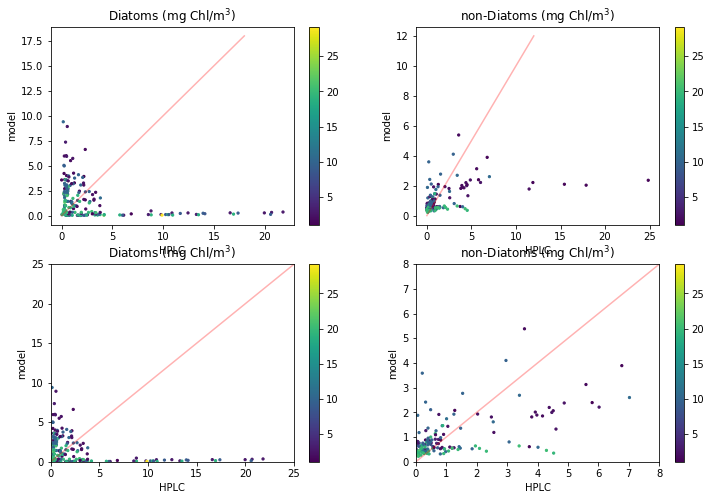

In [36]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
ax=ax.flatten()
m0=ax[0].scatter(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],c=data['Z'],s=5)
ax[0].set_title('Diatoms (mg Chl/m$^3$)')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].plot((0,18),(0,18),'r-',alpha=.3)
fig.colorbar(m0,ax=ax[0])

m1=ax[1].scatter(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),c=data['Z'],s=5)
ax[1].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((0,12),(0,12),'r-',alpha=.3)
fig.colorbar(m1,ax=ax[1])

m2=ax[2].scatter(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],c=data['Z'],s=5)
ax[2].set_title('Diatoms (mg Chl/m$^3$)')
ax[2].set_xlabel('HPLC')
ax[2].set_ylabel('model')
ax[2].plot((0,25),(0,25),'r-',alpha=.3)
ax[2].set_xlim((0,25))
ax[2].set_ylim((0,25))
fig.colorbar(m2,ax=ax[2])

m3=ax[3].scatter(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),c=data['Z'],s=5)
ax[3].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[3].set_xlabel('HPLC')
ax[3].set_ylabel('model')
ax[3].plot((0,12),(0,12),'r-',alpha=.3)
ax[3].set_xlim((0,8))
ax[3].set_ylim((0,8))
fig.colorbar(m3,ax=ax[3])

In [39]:
def logt(x):
    return np.log10(x+.001)

In [44]:
logt(data['Diatoms-1'].astype(np.float)+data['Diatoms-2'].astype(np.float))

0      0.786705
1      0.777465
2      0.619578
3      0.990800
4      0.945610
         ...   
167   -0.164509
168   -0.420451
169   -0.144978
170   -0.300427
171   -0.470969
Length: 172, dtype: float64

(-3.1, 2.0)

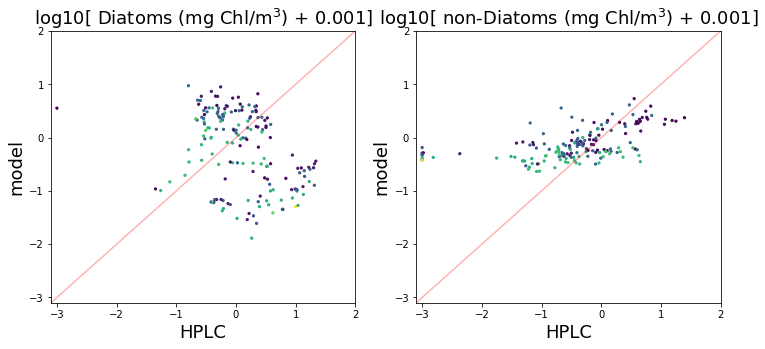

In [47]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(logt(data['Diatoms-1'].astype(np.float)+data['Diatoms-2'].astype(np.float)),
           logt(Chl_N*data['mod_diatoms'].astype(np.float)),c=data['Z'],s=5)
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)
ax[0].set_xlabel('HPLC',fontsize=18)
ax[0].set_ylabel('model',fontsize=18)
ax[0].set_xlim(-3.1,2)
ax[0].set_ylim(-3.1,2)
ax[0].plot((-6,3),(-6,3),'r-',alpha=.3)

ax[1].scatter(logt(data['other'].astype(np.float)),
           logt(Chl_N*(data['mod_flagellates'].astype(np.float)+data['mod_ciliates'].astype(np.float))),c=data['Z'],s=5)
ax[1].set_title('log10[ non-Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)
ax[1].set_xlabel('HPLC',fontsize=18)
ax[1].set_ylabel('model',fontsize=18)
ax[1].plot((-6,3),(-6,3),'r-',alpha=.3)
ax[1].set_xlim(-3.1,2)
ax[1].set_ylim(-3.1,2)

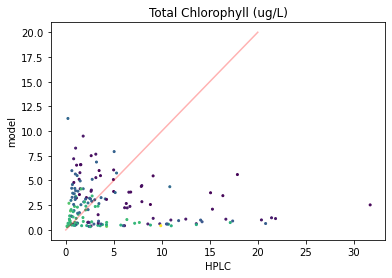

In [51]:
plt.scatter(data['T chl a'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']),
           c=data['Z'],s=4)
plt.title('Total Chlorophyll (ug/L)')
plt.xlabel('HPLC')
plt.ylabel('model')
plt.plot((0,20),(0,20),'r-',alpha=.3)

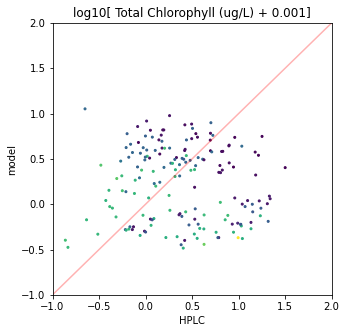

In [52]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(logt(data['T chl a'].astype(np.float)),
        logt(Chl_N*(data['mod_flagellates'].astype(np.float)+data['mod_ciliates'].astype(np.float)+\
                    data['mod_diatoms'].astype(np.float))),c=data['Z'],s=4)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001]')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);

In [53]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

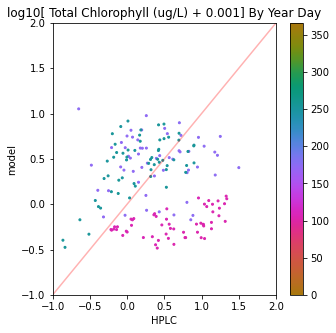

In [75]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(logt(data['T chl a'].astype(np.float)),
             logt(Chl_N*(data['mod_flagellates'].astype(np.float)+data['mod_ciliates'].astype(np.float)\
                         +data['mod_diatoms'].astype(np.float))),
          c=data['yd'],s=4,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001] By Year Day')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);
fig.colorbar(m)

In [76]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

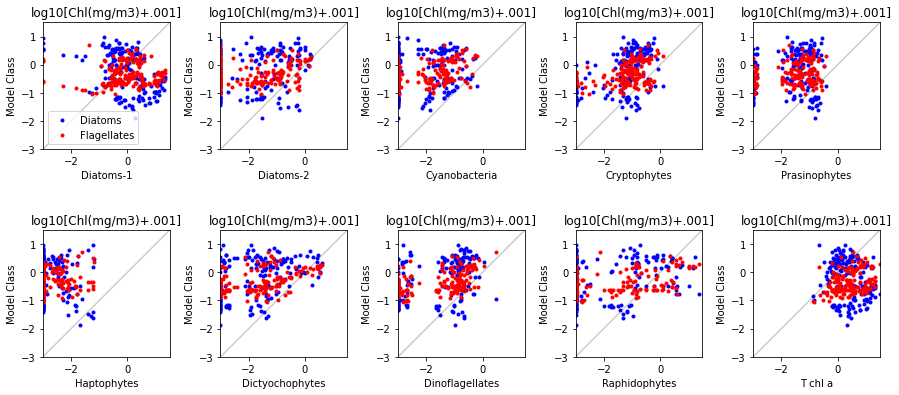

In [79]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','T chl a')

mvar1=Chl_N*data['mod_diatoms'].astype(np.float)
mvar2=Chl_N*data['mod_flagellates'].astype(np.float)

for ii in range(0,len(chplc)):
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].astype(np.float)),logt(mvar1),'.',color='blue',label='Diatoms')
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].astype(np.float)),logt(mvar2),'.',color='red',label='Flagellates')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(chplc[ii])
    ax[ii].set_title('log10[Chl(mg/m3)+.001]')
    ax[ii].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
    ax[ii].set_xlim((-3,1.5))
    ax[ii].set_ylim((-3,1.5))
    ax[ii].set_aspect(1)
ax[0].legend()


(-3.0, 1.5)

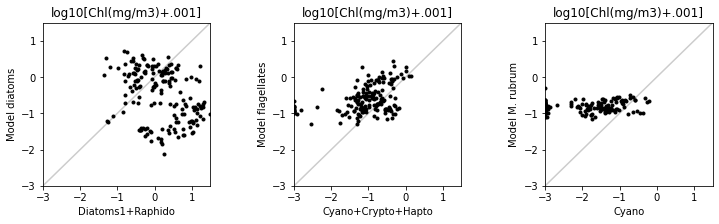

In [80]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.5)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot(logt(data['Diatoms-1'].astype(np.float)+data['Raphidophytes'].astype(np.float)),
           logt(data['mod_diatoms'].astype(np.float)),'k.')
ax[0].set_ylabel('Model diatoms')
ax[0].set_xlabel('Diatoms1+Raphido')
ax[0].set_title('log10[Chl(mg/m3)+.001]')
ax[0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[0].set_xlim((-3,1.5))
ax[0].set_ylim((-3,1.5))

ax[1].plot(logt(data['Cyanobacteria'].astype(np.float)+data['Cryptophytes'].astype(np.float)+\
                data['Haptophytes'].astype(np.float)),logt(data['mod_flagellates'].astype(np.float)),'k.')
ax[1].set_ylabel('Model flagellates')
ax[1].set_xlabel('Cyano+Crypto+Hapto')
ax[1].set_title('log10[Chl(mg/m3)+.001]')
ax[1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[1].set_xlim((-3,1.5))
ax[1].set_ylim((-3,1.5))


ax[2].plot(logt(data['Cyanobacteria'].astype(np.float)),logt(data['mod_ciliates'].astype(np.float)),'k.')
ax[2].set_ylabel('Model M. rubrum')
ax[2].set_xlabel('Cyano')
ax[2].set_title('log10[Chl(mg/m3)+.001]')
ax[2].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[2].set_xlim((-3,1.5))
ax[2].set_ylim((-3,1.5))

In [82]:
data['mod_diatoms_chl']=Chl_N*data['mod_diatoms']
data['mod_flagellates_chl']=Chl_N*data['mod_flagellates']
data['mod_ciliates_chl']=Chl_N*data['mod_ciliates']
data['mod_TChl']=data['mod_diatoms_chl']+data['mod_flagellates_chl']+data['mod_ciliates_chl']
data['CCPH']=data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']
data['DD']=data['Diatoms-1']+data['Diatoms-2']
data['TchlA (ug/L)']=data['T chl a']
dfVars=data.loc[:,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]

### New groups Model-Obs Comparison:

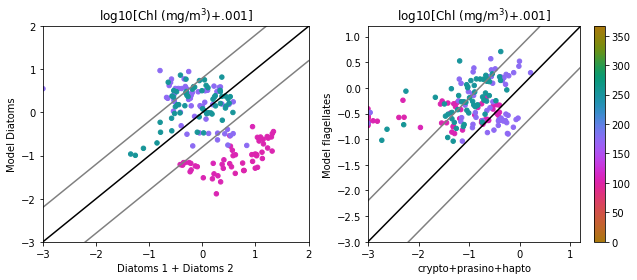

In [84]:
thresh=.8
msize=20
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data['DD'].astype(np.float)),logt(data['mod_diatoms_chl'].astype(np.float)),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data['CCPH'].astype(np.float)),logt(data['mod_flagellates_chl'].astype(np.float)),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])

(array([38., 21.,  1.,  0.,  1., 19., 33.,  4.,  0.,  0.,  0.,  0., 20.,
        31.,  2.,  1.,  0.,  0.,  0.,  1.]),
 array([1.0907020648406247, 2.4934786846893675, 3.8962553045381103,
        5.2990319243868536, 6.701808544235596, 8.104585164084337,
        9.507361783933082, 10.910138403781826, 12.312915023630566,
        13.71569164347931, 15.118468263328051, 16.521244883176795,
        17.92402150302554, 19.32679812287428, 20.729574742723024,
        22.132351362571764, 23.53512798242051, 24.937904602269253,
        26.340681222117993, 27.743457841966737, 29.14623446181548],
       dtype=object),
 <BarContainer object of 20 artists>)

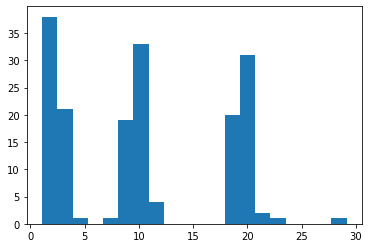

In [87]:
plt.hist(data['Z'],20)

Diatoms/DD


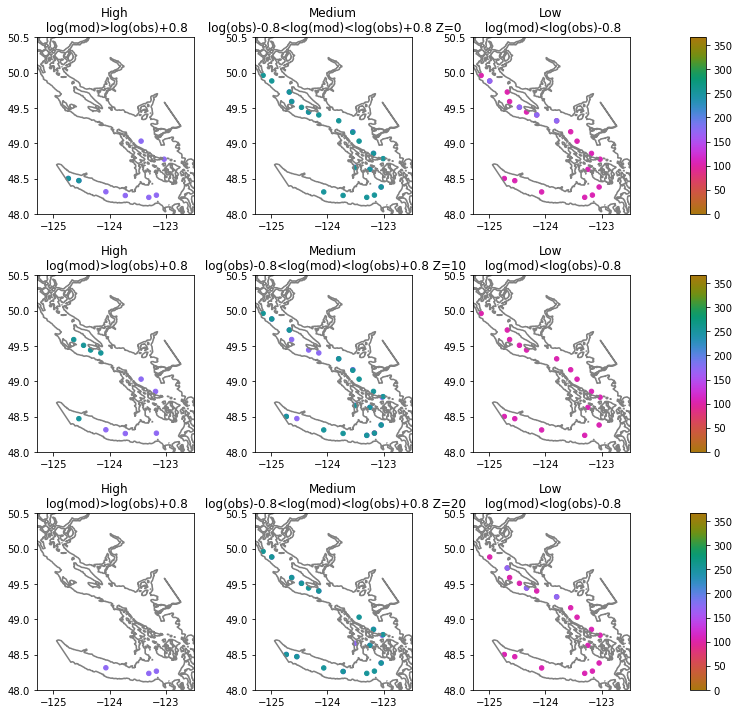

In [101]:
print('Diatoms/DD')
fig,ax=plt.subplots(3,4,figsize=(12,12),gridspec_kw={'width_ratios': [1,1,1,.1],'wspace':.5,'hspace':.35},)
ax=ax.flatten()
for iax in ax:
    iax.contour(navlon,navlat,tmask[0,:,:],levels=[0.5,],colors='gray')
    iax.set_xlim(-125.3,-122.5)
    iax.set_ylim(48,50.5)
xdata=data.loc[data.Z<5]
sc=0
ihi=logt(xdata['mod_diatoms_chl'].astype(np.float))>(logt(xdata['DD'].astype(np.float))+thresh)
ilo=logt(xdata['mod_diatoms_chl'].astype(np.float))<(logt(xdata['DD'].astype(np.float))-thresh)
idata=xdata.loc[(xdata.DD>=0)&ihi]
ax[0+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0+sc].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=xdata.loc[(xdata.DD>=0)&(~ihi)&(~ilo)]
ax[1+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1+sc].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh)+' Z=0')
idata=xdata.loc[(xdata.DD>=0)&ilo]
m=ax[2+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2+sc].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3+sc]);


xdata=data.loc[(data.Z>8)&(data.Z<12)]
sc=4
ihi=logt(xdata['mod_diatoms_chl'].astype(np.float))>(logt(xdata['DD'].astype(np.float))+thresh)
ilo=logt(xdata['mod_diatoms_chl'].astype(np.float))<(logt(xdata['DD'].astype(np.float))-thresh)
idata=xdata.loc[(xdata.DD>=0)&ihi]
ax[0+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0+sc].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=xdata.loc[(xdata.DD>=0)&(~ihi)&(~ilo)]
ax[1+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1+sc].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh)+' Z=10')
idata=xdata.loc[(xdata.DD>=0)&ilo]
m=ax[2+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2+sc].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3+sc]);

xdata=data.loc[(data.Z>18)&(data.Z<22)]
sc=8
ihi=logt(xdata['mod_diatoms_chl'].astype(np.float))>(logt(xdata['DD'].astype(np.float))+thresh)
ilo=logt(xdata['mod_diatoms_chl'].astype(np.float))<(logt(xdata['DD'].astype(np.float))-thresh)
idata=xdata.loc[(xdata.DD>=0)&ihi]
ax[0+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0+sc].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=xdata.loc[(xdata.DD>=0)&(~ihi)&(~ilo)]
ax[1+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1+sc].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh)+' Z=20')
idata=xdata.loc[(xdata.DD>=0)&ilo]
m=ax[2+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2+sc].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3+sc]);

Flagellates/CCPH


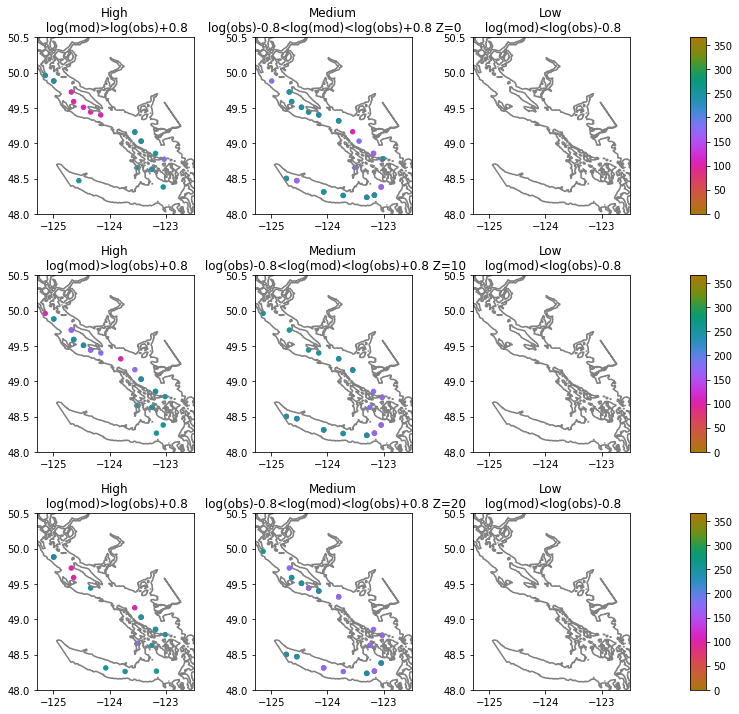

In [102]:
print('Flagellates/CCPH')
fig,ax=plt.subplots(3,4,figsize=(12,12),gridspec_kw={'width_ratios': [1,1,1,.1],'wspace':.5,'hspace':.35},)
ax=ax.flatten()
for iax in ax:
    iax.contour(navlon,navlat,tmask[0,:,:],levels=[0.5,],colors='gray')
    iax.set_xlim(-125.3,-122.5)
    iax.set_ylim(48,50.5)
xdata=data.loc[data.Z<5]
sc=0
ihi=logt(xdata['mod_flagellates_chl'].astype(np.float))>(logt(xdata['CCPH'].astype(np.float))+thresh)
ilo=logt(xdata['mod_flagellates_chl'].astype(np.float))<(logt(xdata['CCPH'].astype(np.float))-thresh)
idata=xdata.loc[(xdata.DD>=0)&ihi]
ax[0+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0+sc].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=xdata.loc[(xdata.DD>=0)&(~ihi)&(~ilo)]
ax[1+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1+sc].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh)+' Z=0')
idata=xdata.loc[(xdata.DD>=0)&ilo]
m=ax[2+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2+sc].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3+sc]);


xdata=data.loc[(data.Z>8)&(data.Z<12)]
sc=4
ihi=logt(xdata['mod_flagellates_chl'].astype(np.float))>(logt(xdata['CCPH'].astype(np.float))+thresh)
ilo=logt(xdata['mod_flagellates_chl'].astype(np.float))<(logt(xdata['CCPH'].astype(np.float))-thresh)
idata=xdata.loc[(xdata.DD>=0)&ihi]
ax[0+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0+sc].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=xdata.loc[(xdata.DD>=0)&(~ihi)&(~ilo)]
ax[1+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1+sc].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh)+' Z=10')
idata=xdata.loc[(xdata.DD>=0)&ilo]
m=ax[2+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2+sc].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3+sc]);

xdata=data.loc[(data.Z>18)&(data.Z<22)]
sc=8
ihi=logt(xdata['mod_flagellates_chl'].astype(np.float))>(logt(xdata['CCPH'].astype(np.float))+thresh)
ilo=logt(xdata['mod_flagellates_chl'].astype(np.float))<(logt(xdata['CCPH'].astype(np.float))-thresh)
idata=xdata.loc[(xdata.DD>=0)&ihi]
ax[0+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0+sc].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=xdata.loc[(xdata.DD>=0)&(~ihi)&(~ilo)]
ax[1+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1+sc].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh)+' Z=20')
idata=xdata.loc[(xdata.DD>=0)&ilo]
m=ax[2+sc].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2+sc].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3+sc]);

### Diatom fraction

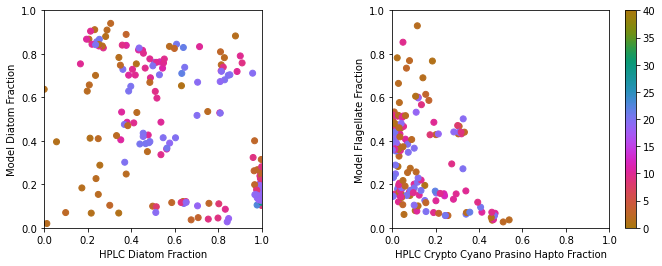

In [103]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
diatFracMod=data['mod_diatoms']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
diatFracObs=data['DD']/data['TchlA (ug/L)']
m=ax[0].scatter(diatFracObs,diatFracMod,
          c=data['Z'],cmap=cmocean.cm.phase,vmin=0,vmax=40)
ax[0].set_xlabel('HPLC Diatom Fraction')
ax[0].set_ylabel('Model Diatom Fraction')
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))
flFracMod=data['mod_flagellates']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
CCPHFracObs=data['CCPH']/data['TchlA (ug/L)']
m=ax[1].scatter(CCPHFracObs,flFracMod,
          c=data['Z'],cmap=cmocean.cm.phase,vmin=0,vmax=40)
ax[1].set_xlabel('HPLC Crypto Cyano Prasino Hapto Fraction')
ax[1].set_ylabel('Model Flagellate Fraction')
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

fig.colorbar(m)

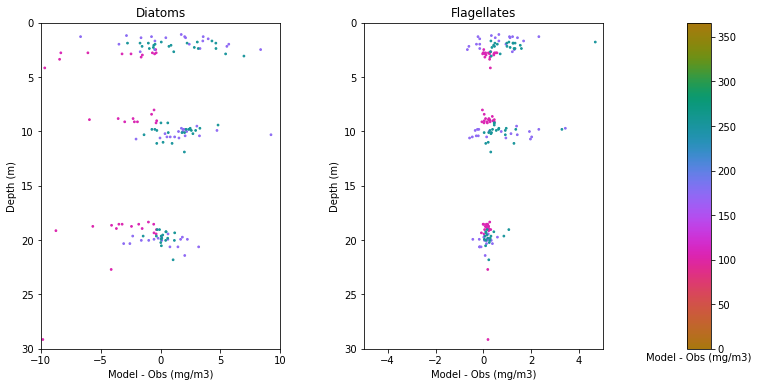

In [113]:
fig,ax=plt.subplots(1,3,figsize=(12,6),gridspec_kw={'width_ratios': [1,1,.1],'wspace':.5})
m=ax[0].scatter(data['mod_diatoms_chl']-data['DD'],data['Z'],
              c=data.yd,s=3,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].scatter(data['mod_flagellates_chl']-data['CCPH'],data['Z'],
              c=data.yd,s=3,cmap=cmocean.cm.phase,vmin=0,vmax=366)
for iax in ax:
    iax.set_ylabel('Depth (m)')
    iax.set_ylim(30,0)
    iax.set_xlabel('Model - Obs (mg/m3)')
ax[0].set_title('Diatoms')
ax[1].set_title('Flagellates')
ax[0].set_xlim(-10,10)
ax[1].set_xlim(-5,5)
fig.colorbar(m,cax=ax[2])